In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()
df.count

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


<bound method DataFrame.count of                                                  content  target  \
0      From: lerxst@wam.umd.edu (where's my thing)\nS...       7   
1      From: guykuo@carson.u.washington.edu (Guy Kuo)...       4   
2      From: twillis@ec.ecn.purdue.edu (Thomas E Will...       4   
3      From: jgreen@amber (Joe Green)\nSubject: Re: W...       1   
4      From: jcm@head-cfa.harvard.edu (Jonathan McDow...      14   
...                                                  ...     ...   
11309  From: jim.zisfein@factory.com (Jim Zisfein) \n...      13   
11310  From: ebodin@pearl.tufts.edu\nSubject: Screen ...       4   
11311  From: westes@netcom.com (Will Estes)\nSubject:...       3   
11312  From: steve@hcrlgw (Steven Collins)\nSubject: ...       1   
11313  From: gunning@cco.caltech.edu (Kevin J. Gunnin...       8   

                   target_names  
0                     rec.autos  
1         comp.sys.mac.hardware  
2         comp.sys.mac.hardware  
3             

In [4]:
# Convert to list
data = df.content.values.tolist()
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


In [5]:
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

#Convert sentence into word array and remove punctuations
def sent_proc(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words=list(sent_proc(data))

print(data_words[1])

['from', 'guy', 'kuo', 'subject', 'si', 'clock', 'poll', 'final', 'call', 'summary', 'final', 'call', 'for', 'si', 'clock', 'reports', 'keywords', 'si', 'acceleration', 'clock', 'upgrade', 'article', 'shelley', 'qvfo', 'innc', 'organization', 'university', 'of', 'washington', 'lines', 'nntp', 'posting', 'host', 'carson', 'washington', 'edu', 'fair', 'number', 'of', 'brave', 'souls', 'who', 'upgraded', 'their', 'si', 'clock', 'oscillator', 'have', 'shared', 'their', 'experiences', 'for', 'this', 'poll', 'please', 'send', 'brief', 'message', 'detailing', 'your', 'experiences', 'with', 'the', 'procedure', 'top', 'speed', 'attained', 'cpu', 'rated', 'speed', 'add', 'on', 'cards', 'and', 'adapters', 'heat', 'sinks', 'hour', 'of', 'usage', 'per', 'day', 'floppy', 'disk', 'functionality', 'with', 'and', 'floppies', 'are', 'especially', 'requested', 'will', 'be', 'summarizing', 'in', 'the', 'next', 'two', 'days', 'so', 'please', 'add', 'to', 'the', 'network', 'knowledge', 'base', 'if', 'you', 

In [6]:
# Build bigram and trigram
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) 
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

print(trigram_mod[bigram_mod[data_words[0]]])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [7]:
# Remove stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Remove words that are not noun, adj, vb, adv
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)


nlp = spacy.load('en', disable=['parser', 'ner'])

# Lemmatization with pos tagging
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[0])

['where', 'thing', 'car', 'nntp_poste', 'host', 'park', 'line', 'wonder', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']


In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 5), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)]]


In [10]:
id2word[0]

'addition'

In [11]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=14, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [12]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.057*"team" + 0.052*"game" + 0.042*"year" + 0.039*"play" + 0.036*"win" + '
  '0.028*"player" + 0.017*"fan" + 0.016*"hockey" + 0.016*"score" + '
  '0.015*"goal"'),
 (1,
  '0.024*"may" + 0.016*"also" + 0.015*"number" + 0.014*"use" + 0.014*"case" + '
  '0.013*"group" + 0.011*"provide" + 0.011*"system" + 0.010*"part" + '
  '0.009*"issue"'),
 (2,
  '0.102*"season" + 0.055*"pen" + 0.042*"bill" + 0.042*"trade" + 0.033*"coach" '
  '+ 0.026*"penguin" + 0.023*"injury" + 0.021*"leafs" + 0.020*"ranger" + '
  '0.017*"strip"'),
 (3,
  '0.056*"card" + 0.049*"bit" + 0.042*"driver" + 0.030*"chip" + 0.030*"color" '
  '+ 0.027*"memory" + 0.025*"pc" + 0.024*"fast" + 0.023*"speed" + '
  '0.023*"slow"'),
 (4,
  '0.097*"space" + 0.037*"launch" + 0.029*"orbit" + 0.028*"mission" + '
  '0.027*"commercial" + 0.026*"earth" + 0.025*"satellite" + 0.024*"plane" + '
  '0.022*"flight" + 0.017*"fuel"'),
 (5,
  '0.027*"people" + 0.019*"government" + 0.016*"child" + 0.015*"kill" + '
  '0.011*"death" + 0.011*"say

In [13]:
from wordcloud import WordCloud

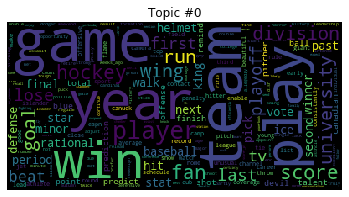

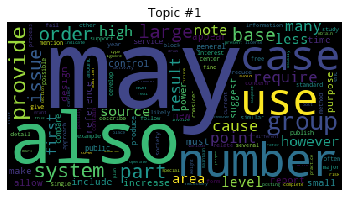

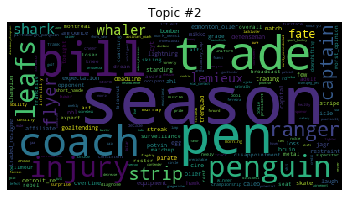

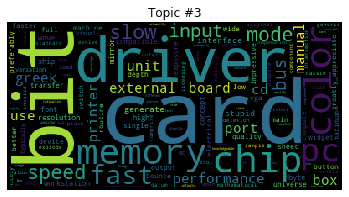

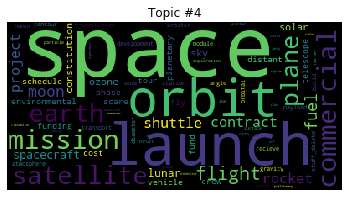

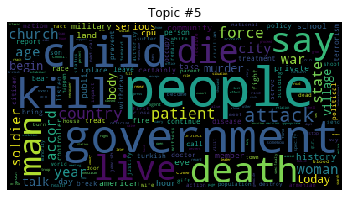

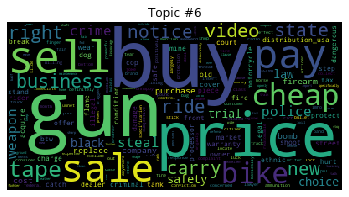

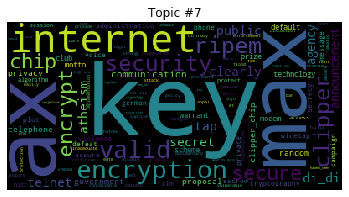

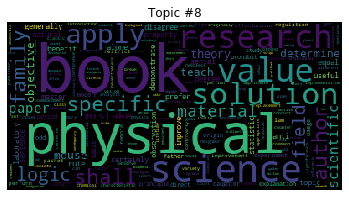

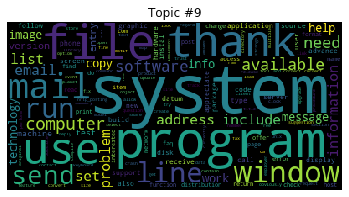

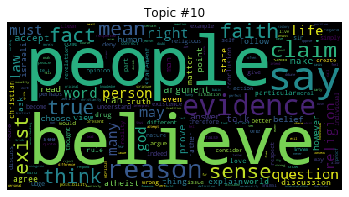

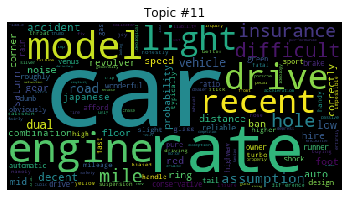

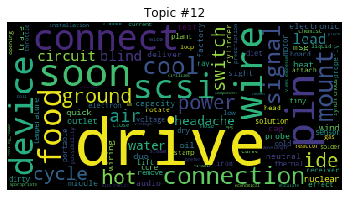

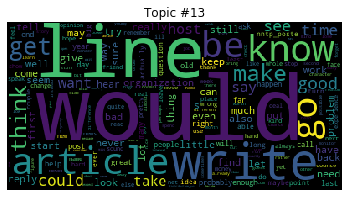

In [14]:
import matplotlib.pyplot as plt
for t in range(lda_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(lda_model.show_topic(t,200))))
    plt.axis("off")
    plt.title("Topic #"+str(t))
    plt.show()

In [15]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -11.055526384367775

Coherence Score:  0.492205544748875


In [16]:
import os
from gensim.models.wrappers import LdaMallet

In [17]:
os.environ.update({'MALLET_HOME':r'C:/Users/User/Desktop/fyp/mallet-2.0.8/'})

In [18]:
root = os.getcwd()
mallet_path = 'C:/Users/User/Desktop/fyp/mallet-2.0.8/bin/mallet' 

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=14, id2word=id2word, prefix = 'C:/Users/User/Desktop/fyp/')

In [19]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(4,
  [('line', 0.15331616674785997),
   ('write', 0.13229869858723642),
   ('ax', 0.1094485814368896),
   ('article', 0.09346509847588559),
   ('max', 0.08819913239149094),
   ('host', 0.06776161644280511),
   ('organization', 0.043797991045537846),
   ('nntp_poste', 0.02498434129027768),
   ('reply', 0.021574222284083792),
   ('ca', 0.01145985570788967)]),
 (6,
  [('game', 0.027146927841384134),
   ('year', 0.02644735270530824),
   ('team', 0.023222481956080333),
   ('good', 0.02259115805279233),
   ('play', 0.021004316890473836),
   ('player', 0.01605610251335165),
   ('line', 0.015868411623184944),
   ('win', 0.014947019980548398),
   ('run', 0.010118245260805023),
   ('season', 0.009879365946047401)]),
 (7,
  [('car', 0.028586127068507244),
   ('good', 0.018022807167967076),
   ('write', 0.01625653776901312),
   ('line', 0.01500471576781274),
   ('buy', 0.014936122781445597),
   ('article', 0.013701449026837006),
   ('bike', 0.010871988339192317),
   ('make', 0.009911686530052302

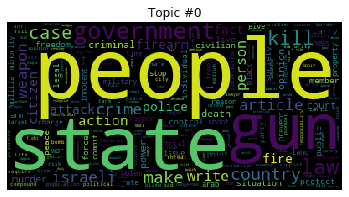

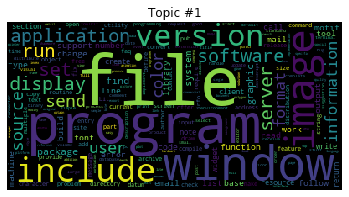

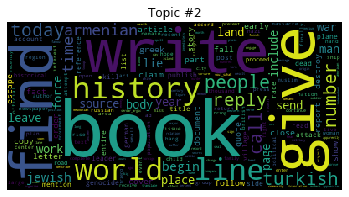

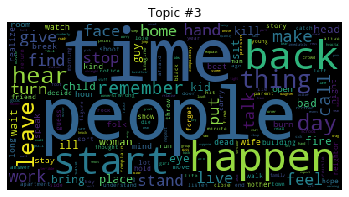

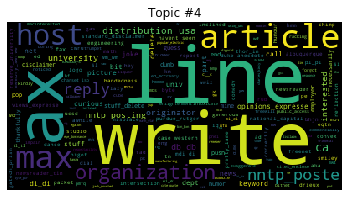

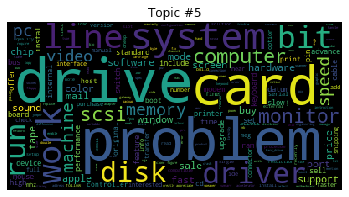

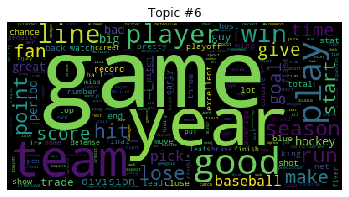

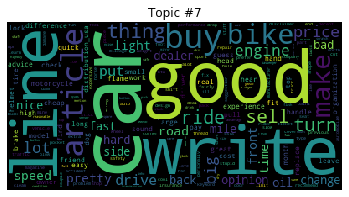

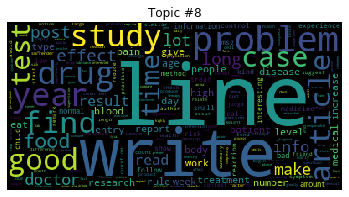

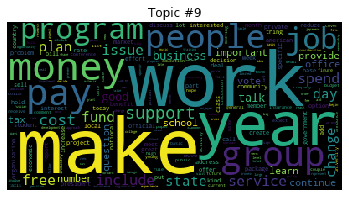

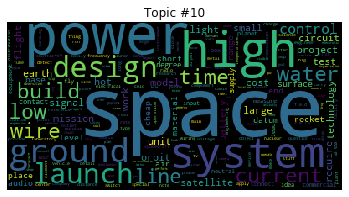

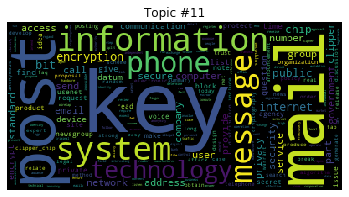

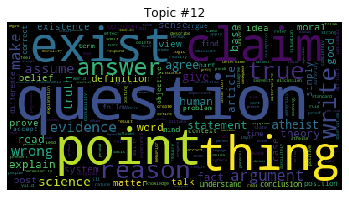

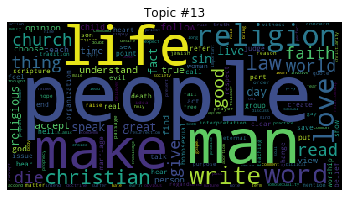

In [20]:
import matplotlib.pyplot as plt
for t in range(ldamallet.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(ldamallet.show_topic(t,200))))
    plt.axis("off")
    plt.title("Topic #"+str(t))
    plt.show()

In [21]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [22]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

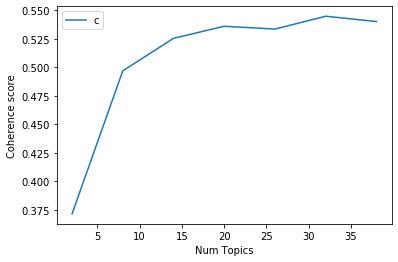

In [23]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [24]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3716
Num Topics = 8  has Coherence Value of 0.4969
Num Topics = 14  has Coherence Value of 0.5254
Num Topics = 20  has Coherence Value of 0.536
Num Topics = 26  has Coherence Value of 0.5335
Num Topics = 32  has Coherence Value of 0.5447
Num Topics = 38  has Coherence Value of 0.5401


In [41]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.191*"ax" + 0.160*"line" + 0.154*"max" + 0.104*"host" + 0.044*"nntp_poste" '
  '+ 0.021*"organization" + 0.020*"ca" + 0.011*"distribution_usa" + '
  '0.009*"reply" + 0.008*"nntp_posting"'),
 (1,
  '0.029*"law" + 0.024*"people" + 0.021*"state" + 0.015*"government" + '
  '0.012*"case" + 0.010*"system" + 0.010*"person" + 0.009*"moral" + '
  '0.009*"free" + 0.009*"power"'),
 (2,
  '0.039*"key" + 0.016*"system" + 0.015*"bit" + 0.015*"encryption" + '
  '0.013*"chip" + 0.013*"technology" + 0.011*"public" + 0.011*"message" + '
  '0.011*"government" + 0.011*"phone"'),
 (3,
  '0.010*"problem" + 0.010*"study" + 0.009*"food" + 0.008*"doctor" + '
  '0.008*"effect" + 0.007*"patient" + 0.007*"find" + 0.007*"eat" + '
  '0.007*"result" + 0.007*"test"'),
 (4,
  '0.030*"file" + 0.025*"send" + 0.021*"mail" + 0.020*"information" + '
  '0.019*"list" + 0.018*"post" + 0.017*"address" + 0.014*"email" + '
  '0.014*"include" + 0.012*"internet"'),
 (5,
  '0.016*"power" + 0.015*"line" + 0.011*"work" + 0.0

In [42]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.1769,"car, price, buy, sell, bike, sale, ride, engin...",From: (wheres my thing) Subject: WHAT car is t...
1,1,11.0,0.1359,"drive, card, problem, system, driver, work, bi...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,7.0,0.1295,"good, make, thing, time, bad, lot, pretty, giv...",From: (Thomas E Willis) Subject: PB questions....
3,3,17.0,0.1075,"write, line, article, organization, reply, pos...",From: (Joe Green) Subject: Re: Weitek P9000 ? ...
4,4,18.0,0.1389,"window, file, program, image, version, display...",From: (Jonathan McDowell) Subject: Re: Shuttle...
5,5,14.0,0.3088,"gun, crime, weapon, kill, drug, rate, firearm,...",From: (Foxvog Douglas) Subject: Re: Rewording ...
6,6,4.0,0.1283,"file, send, mail, information, list, post, add...",From: (brian manning delaney) Subject: Brain T...
7,7,11.0,0.4913,"drive, card, problem, system, driver, work, bi...",From: (GRUBB) Subject: Re: IDE vs SCSI Organiz...
8,8,18.0,0.1437,"window, file, program, image, version, display...",From: Subject: WIn 3.0 ICON HELP PLEASE! Organ...
9,9,11.0,0.2562,"drive, card, problem, system, driver, work, bi...",From: (Stan Kerr) Subject: Re: Sigma Designs D...


In [43]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9718,"ax, line, max, host, nntp_poste, organization,...",Subject: roman.bmp 12/14 From: (Cliff) Reply-T...
1,1.0,0.5727,"law, people, state, government, case, system, ...",From: (Robert A. Boudrie) Subject: Re: Some mo...
2,2.0,0.8857,"key, system, bit, encryption, chip, technology...",From: (Jim Gillogly) Subject: Clipper Chip and...
3,3.0,0.6806,"problem, study, food, doctor, effect, patient,...","From: Subject: Candida(yeast) Bloom, Fact or F..."
4,4.0,0.9238,"file, send, mail, information, list, post, add...",From: (Landon C. Noll) Subject: 10th Internati...


In [44]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts.sort_index(), topic_contribution.sort_index()], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"ax, line, max, host, nntp_poste, organization,...",308,0.0272
1.0,1.0,"law, people, state, government, case, system, ...",401,0.0354
2.0,2.0,"key, system, bit, encryption, chip, technology...",507,0.0448
3.0,3.0,"problem, study, food, doctor, effect, patient,...",492,0.0435
4.0,4.0,"file, send, mail, information, list, post, add...",408,0.0361
5.0,5.0,"power, line, work, ground, current, high, wire...",561,0.0496
6.0,6.0,"people, israeli, attack, war, kill, turkish, l...",461,0.0407
7.0,7.0,"good, make, thing, time, bad, lot, pretty, giv...",212,0.0187
8.0,8.0,"question, exist, true, claim, argument, reason...",406,0.0359
9.0,9.0,"car, price, buy, sell, bike, sale, ride, engin...",1101,0.0973


In [45]:
optimal_model.save('lda.model')

In [46]:
testing123= gensim.models.LdaModel.load('lda.model')

In [47]:
pprint(testing123.show_topics(formatted=False))

[(2,
  [('key', 0.039276373147340886),
   ('system', 0.015998256320836967),
   ('bit', 0.014755884917175239),
   ('encryption', 0.014516129032258065),
   ('chip', 0.013164777680906714),
   ('technology', 0.012816041848299913),
   ('public', 0.011181342632955536),
   ('message', 0.01094158674803836),
   ('government', 0.010789014821272886),
   ('phone', 0.010680034873583261)]),
 (16,
  [('write', 0.05905490883963217),
   ('article', 0.02830489555094881),
   ('line', 0.025168766278637112),
   ('people', 0.01860415670015415),
   ('opinion', 0.014830170626694308),
   ('make', 0.01350130229096901),
   ('start', 0.013288683357252964),
   ('show', 0.012783713389677352),
   ('hear', 0.012225588688672726),
   ('man', 0.011561154520810078)]),
 (6,
  [('people', 0.01572720375648465),
   ('israeli', 0.010621501363571121),
   ('attack', 0.010231909614714265),
   ('war', 0.009883327523631816),
   ('kill', 0.009534745432549365),
   ('turkish', 0.008899095737046074),
   ('land', 0.008427484672640408),

In [48]:
test_data="the players today play a good season and win"

In [49]:
doc = test_data.split()
doc_vector = id2word.doc2bow(doc)
doc_topics = testing123[doc_vector]

In [50]:
doc

['the', 'players', 'today', 'play', 'a', 'good', 'season', 'and', 'win']

In [51]:
doc_topics

[(0, 0.04545454545454546),
 (1, 0.04545454545454546),
 (2, 0.04545454545454546),
 (3, 0.04545454545454546),
 (4, 0.04545454545454546),
 (5, 0.04545454545454546),
 (6, 0.04949494949494951),
 (7, 0.05959595959595961),
 (8, 0.04545454545454546),
 (9, 0.04545454545454546),
 (10, 0.04545454545454546),
 (11, 0.04545454545454546),
 (12, 0.04545454545454546),
 (13, 0.10202020202020205),
 (14, 0.04545454545454546),
 (15, 0.04747474747474749),
 (16, 0.05353535353535355),
 (17, 0.04545454545454546),
 (18, 0.04545454545454546),
 (19, 0.05151515151515153)]

In [52]:
id2word.save("dic1.bin")

In [53]:
abc = corpora.Dictionary.load("dic1.bin")

In [54]:
test_data="A very specific, somewhat miraculous example of the truth of God working to help His followers is soemthing that happened to me"

In [55]:
testing123= gensim.models.LdaModel.load('lda.model')
pprint(testing123.show_topics(formatted=False))
from gensim import corpora
id2word = corpora.Dictionary.load("dic1.bin")
doc = test_data.split()
doc_vector = abc.doc2bow(doc)
doc_topics = testing123[doc_vector]

[(14,
  [('gun', 0.03210778141526064),
   ('crime', 0.011986905061697306),
   ('weapon', 0.011961722488038277),
   ('kill', 0.011583983883152859),
   ('drug', 0.01082850667338202),
   ('rate', 0.00984638630067993),
   ('firearm', 0.009544195416771595),
   ('people', 0.009393099974817427),
   ('carry', 0.008738353059682699),
   ('police', 0.008335431881138252)]),
 (11,
  [('drive', 0.032805067935072416),
   ('card', 0.02593690676791161),
   ('problem', 0.025851587995648743),
   ('system', 0.02194825416462257),
   ('driver', 0.01751167800695348),
   ('work', 0.017085084145639143),
   ('bit', 0.016658490284324808),
   ('disk', 0.01439754281935883),
   ('run', 0.01392828957191306),
   ('scsi', 0.012904464304758655)]),
 (8,
  [('question', 0.025442250574412045),
   ('exist', 0.01783946350849009),
   ('true', 0.01778342330898698),
   ('claim', 0.015859376459380195),
   ('argument', 0.01451441167130555),
   ('reason', 0.01399136980927652),
   ('point', 0.013729848878262006),
   ('answer', 0.0

In [56]:
doc_topics

[(0, 0.047169811320754734),
 (1, 0.047169811320754734),
 (2, 0.04926624737945494),
 (3, 0.047169811320754734),
 (4, 0.047169811320754734),
 (5, 0.05345911949685536),
 (6, 0.047169811320754734),
 (7, 0.047169811320754734),
 (8, 0.0618448637316562),
 (9, 0.047169811320754734),
 (10, 0.047169811320754734),
 (11, 0.05136268343815515),
 (12, 0.047169811320754734),
 (13, 0.047169811320754734),
 (14, 0.047169811320754734),
 (15, 0.07023060796645704),
 (16, 0.047169811320754734),
 (17, 0.047169811320754734),
 (18, 0.047169811320754734),
 (19, 0.05345911949685536)]